In [1]:
import pandas as pd
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalCrossentropy
import numpy as np
from sklearn.model_selection import train_test_split
import string
import seaborn as sns

In [2]:
#Loading in dataset

dataset = pd.read_csv(r'dataset.csv')
print(dataset.head())

dataset.describe()



            Disease   Symptom_1              Symptom_2              Symptom_3  \
0  Fungal infection     itching              skin_rash   nodal_skin_eruptions   
1  Fungal infection   skin_rash   nodal_skin_eruptions    dischromic _patches   
2  Fungal infection     itching   nodal_skin_eruptions    dischromic _patches   
3  Fungal infection     itching              skin_rash    dischromic _patches   
4  Fungal infection     itching              skin_rash   nodal_skin_eruptions   

              Symptom_4 Symptom_5 Symptom_6 Symptom_7 Symptom_8 Symptom_9  \
0   dischromic _patches       NaN       NaN       NaN       NaN       NaN   
1                   NaN       NaN       NaN       NaN       NaN       NaN   
2                   NaN       NaN       NaN       NaN       NaN       NaN   
3                   NaN       NaN       NaN       NaN       NaN       NaN   
4                   NaN       NaN       NaN       NaN       NaN       NaN   

  Symptom_10 Symptom_11 Symptom_12 Symptom_13 Symp

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
count,4920,4920,4920,4920,4572,3714,2934,2268,1944,1692,1512,1194,744,504,306,240,192,72
unique,41,34,48,54,50,38,32,26,21,22,21,18,11,8,4,3,3,1
top,Tuberculosis,vomiting,vomiting,fatigue,high_fever,headache,nausea,abdominal_pain,abdominal_pain,yellowing_of_eyes,yellowing_of_eyes,irritability,malaise,abnormal_menstruation,chest_pain,chest_pain,loss_of_smell,muscle_pain
freq,120,822,870,726,378,348,390,264,276,228,198,120,126,72,96,144,72,72


In [3]:
#New dataset not including symptoms 5 and above

shortened_dataset = dataset.loc[:, ['Disease', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4']]



# shortened_dataset.apply(remove_ints, axis = 'columns')

X_data = shortened_dataset.loc[:, ['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4']]
Y_data = shortened_dataset.loc[:, 'Disease']

train_x, valid_x, train_y, valid_y = train_test_split(X_data, Y_data, test_size = 0.1, train_size = 0.9)

train_x.astype('string')
valid_x.astype('string')

train_y.astype('string')
valid_y.astype('string')

4765    Bronchial Asthma
3182        Tuberculosis
4872     Osteoarthristis
4476           Diabetes 
1308           Diabetes 
              ...       
4484             Malaria
211          Hepatitis C
3494    Bronchial Asthma
4627           Arthritis
3929     Osteoarthristis
Name: Disease, Length: 492, dtype: string

In [4]:
#list of all unique symptoms 
all_symptoms = []
def add_symptoms(symptom_list):
    [all_symptoms.append(symptom_list[i]) for i in range(len(symptom_list))]

S1_unique = shortened_dataset['Symptom_1'].unique()
S2_unique = shortened_dataset['Symptom_2'].unique()
S3_unique = shortened_dataset['Symptom_3'].unique()
S4_unique = shortened_dataset['Symptom_4'].unique()


add_symptoms(S1_unique)
add_symptoms(S2_unique)
add_symptoms(S3_unique)
add_symptoms(S4_unique)

all_symptoms = list(dict.fromkeys(all_symptoms))

all_symptoms.pop(73) #removing a nan value
all_symptoms.insert(0, 'nan') #adding nan back to the beginning of the list (0 = nothing)
print(all_symptoms)

['nan', 'itching', ' skin_rash', ' continuous_sneezing', ' shivering', ' stomach_pain', ' acidity', ' vomiting', ' indigestion', ' muscle_wasting', ' patches_in_throat', ' fatigue', ' weight_loss', ' sunken_eyes', ' cough', ' headache', ' chest_pain', ' back_pain', ' weakness_in_limbs', ' chills', ' joint_pain', ' yellowish_skin', ' constipation', ' pain_during_bowel_movements', ' breathlessness', ' cramps', ' weight_gain', ' mood_swings', ' neck_pain', ' muscle_weakness', ' stiff_neck', ' pus_filled_pimples', ' burning_micturition', ' bladder_discomfort', ' high_fever', ' nodal_skin_eruptions', ' ulcers_on_tongue', ' loss_of_appetite', ' restlessness', ' dehydration', ' dizziness', ' weakness_of_one_body_side', ' lethargy', ' nausea', ' abdominal_pain', ' pain_in_anal_region', ' sweating', ' bruising', ' cold_hands_and_feets', ' anxiety', ' knee_pain', ' swelling_joints', ' blackheads', ' foul_smell_of urine', ' skin_peeling', ' blister', ' dischromic _patches', ' watering_from_eyes',

In [5]:
sorted(all_symptoms)

#removing random spaces, replacing underscores with spaces
all_symptoms = [i.strip(' ') for i in all_symptoms ]
all_symptoms = [i.replace('_', ' ') for i in all_symptoms]

#doing the same thing for all diseases
all_diseases = []
disease_list = shortened_dataset['Disease'].unique()
[all_diseases.append(disease_list[i]) for i in range(len(disease_list))]

all_diseases = [i.strip(' ') for i in all_diseases ]
all_diseases = [i.replace('_', ' ') for i in all_diseases]

#Converting input to a number representing the index

def data_to_index(condition, reference_list):
    condition = str(condition)
    condition = condition.strip(' ')
    condition = condition.replace('_', ' ')
    condition.lower()
    number = reference_list.index(condition)
    return number 

#Making batches

def index_mod_x(row):
    row.Symptom_1 = data_to_index(row.Symptom_1, all_symptoms)
    row.Symptom_2 = data_to_index(row.Symptom_2, all_symptoms)
    row.Symptom_3 = data_to_index(row.Symptom_3, all_symptoms)
    if row.Symptom_4 != 'nan':
        row.Symptom_4 = data_to_index(row.Symptom_4, all_symptoms)
    return row

def index_mod_y(row):
    row = data_to_index(row, all_diseases)
    return row

idx_train_x = train_x.apply(index_mod_x, axis = 'columns')
idx_valid_x = valid_x.apply(index_mod_x, axis = 'columns')

idx_train_y = train_y.apply(index_mod_y)
idx_valid_y = valid_y.apply(index_mod_y)

idx_train_x.astype(int)
idx_train_y.astype(int)
idx_valid_x.astype(int)
idx_valid_y.astype(int)

print(idx_train_x.loc[0].shape)
print(idx_train_y.shape)
print(idx_valid_x.shape)
print(idx_valid_y.shape)

print(all_diseases)
print(all_symptoms)

(4,)
(4428,)
(492, 4)
(492,)
['Fungal infection', 'Allergy', 'GERD', 'Chronic cholestasis', 'Drug Reaction', 'Peptic ulcer diseae', 'AIDS', 'Diabetes', 'Gastroenteritis', 'Bronchial Asthma', 'Hypertension', 'Migraine', 'Cervical spondylosis', 'Paralysis (brain hemorrhage)', 'Jaundice', 'Malaria', 'Chicken pox', 'Dengue', 'Typhoid', 'hepatitis A', 'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E', 'Alcoholic hepatitis', 'Tuberculosis', 'Common Cold', 'Pneumonia', 'Dimorphic hemmorhoids(piles)', 'Heart attack', 'Varicose veins', 'Hypothyroidism', 'Hyperthyroidism', 'Hypoglycemia', 'Osteoarthristis', 'Arthritis', '(vertigo) Paroymsal  Positional Vertigo', 'Acne', 'Urinary tract infection', 'Psoriasis', 'Impetigo']
['nan', 'itching', 'skin rash', 'continuous sneezing', 'shivering', 'stomach pain', 'acidity', 'vomiting', 'indigestion', 'muscle wasting', 'patches in throat', 'fatigue', 'weight loss', 'sunken eyes', 'cough', 'headache', 'chest pain', 'back pain', 'weakness in limbs',

In [ ]:
idx_train_x = tf.convert_to_tensor(idx_train_x)
idx_train_x = tf.reshape(idx_train_x, [4428, 1, 4])

idx_train_y = tf.convert_to_tensor(idx_train_y)
idx_train_y = tf.reshape(idx_train_y, [4428, 1])

idx_valid_x = tf.convert_to_tensor(idx_valid_x)
idx_valid_x = tf.reshape(idx_valid_x, [492, 1, 4])

idx_valid_y = tf.convert_to_tensor(idx_valid_y)
idx_valid_y = tf.reshape(idx_valid_y, [492, 1])

In [ ]:
#Building the model!

input_shape = [4,]
model = keras.Sequential()

# model.add(Flatten(input_shape = input_shape))
model.add(Dense(25, input_shape = input_shape))
model.add(Dense(1000, activation = 'relu'))
model.add(Dense(600, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation = 'relu'))
model.add(Dense(41, activation = 'softmax'))

model.summary()

checkpoint = ModelCheckpoint('model={epoch:03d}.h5',
                             monitor = 'accuracy',
                             verbose = 1,
                             save_best_only=True,
                             mode = 'auto')

#compile model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(lr = 0.00001), metrics = ['accuracy'])

In [ ]:
model.load_weights(r'model=005.h5')

In [ ]:
#Training model
batch_size = 10
history = model.fit(x = idx_train_x, y = idx_train_y, batch_size = batch_size, epochs = 10, verbose = 1, callbacks = [checkpoint], validation_data=(idx_valid_x, idx_valid_y), steps_per_epoch = 50, validation_steps = 50, shuffle = True)



Migraine


<AxesSubplot:>

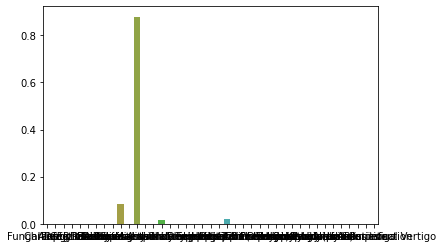

In [38]:

model.load_weights(r'92%.h5')
symptoms_for_model = ['stomach_pain', 'acidity', 'vomiting', 'ulcers on tongue']

index_list = tf.convert_to_tensor(([data_to_index(symptoms_for_model[i], all_symptoms) for i in range(len(symptoms_for_model))]))

index_list = tf.reshape(index_list, [1, 4])

max_value = max(max(model.predict(index_list)))
index = np.where(model.predict(index_list)[0] == max_value)

prediction = all_diseases[index[0][0]]
print(prediction)

prediction_list = model.predict(index_list)[0]



sns.barplot(x = all_diseases, y = prediction_list)
